In [226]:
import pandas as pd
import numpy as np

In [227]:
# New York City Airbnb Open Data
df = pd.read_csv('AB_NYC_2019.csv')


In [228]:
df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [229]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<AxesSubplot:xlabel='price', ylabel='Count'>

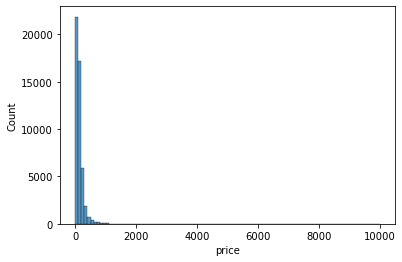

In [230]:
sns.histplot(df.price, bins=100)
# The `price` variable has long tail

In [231]:
base = [
    'latitude',
    'longitude',
    'price',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

df = df[base]

In [232]:
df.head(3)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365


In [262]:
### Question 1

"""
Find a feature with missing values. How many missing values does it have?
df.isnull().sum()
"""

df.isnull().sum()

# ANSWER: reviews_per_month


latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [234]:
### Question 2

"""
What's the median (50% percentile) for variable 'minimum_nights'?
"""

df.minimum_nights.mean()

# ANSWER: 7.029962163820431

7.029962163820431

In [235]:
### Split the data

"""
* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60 % /20 % /20 % distribution.
* Make sure that the target value('price') is not in your dataframe.
* Apply the log transformation to the price variable using the `np.log1p()` function.
"""

n = len(df)

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

In [236]:
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [237]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [238]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

In [239]:
### Question 3

"""
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?
"""


# FIRST
df_train_filled_zeros = df_train.copy()
df_train_filled_zeros['reviews_per_month'] = (
    df_train['reviews_per_month'].fillna(0)
)
X_train_filled_zeros = df_train_filled_zeros.values

# SECOND
reviews_mean = df_train.reviews_per_month.mean()
df_train_filled_mean = df_train.copy()
df_train_filled_mean['reviews_per_month'] = (
    df_train['reviews_per_month'].fillna(reviews_mean)
)
X_train_filled_mean = df_train_filled_mean.values


In [240]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)


In [242]:
# FIRST
w0z, wz = train_linear_regression(X_train_filled_zeros, y_train)
X_val = df_val.fillna(0).values
y_pred = w0z + X_val.dot(wz)
rmse_zeros_val = rmse(y_val, y_pred)

# SECOND
w0m, wm = train_linear_regression(X_train_filled_mean, y_train)
y_pred_mean = w0m + X_train_filled_mean.dot(wm)
X_val = df_val.fillna(reviews_mean).values
y_pred = w0m + X_val.dot(wm)
rmse_mean_val = rmse(y_val, y_pred)

print(round(rmse_zeros_val, 2), round(rmse_mean_val,2))  # 0.64, 0.64

# ANSWER TO QUESTION 3
# Both RMSE scores are nearly identical


0.64 0.64


In [244]:
### Question 4

"""
* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.
"""

def train_linear_regression_regularized(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]


In [249]:
X_train = df_train.fillna(0).values
X_val = df_val.fillna(0).values

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_regularized(X_train, y_train, r=r)

    y_pred = w0 + X_val.dot(w)
    rmse_score = round(rmse(y_val, y_pred), 2)
    print(f"r={r} | rmse={rmse_score}\n")

# ANSWER to Question 4
# The best RMSE is for r=0

r=0 | rmse=0.64

r=1e-06 | rmse=0.64

r=0.0001 | rmse=0.64

r=0.001 | rmse=0.64

r=0.01 | rmse=0.66

r=0.1 | rmse=0.68

r=1 | rmse=0.68

r=5 | rmse=0.68

r=10 | rmse=0.68



In [ ]:
### Question 5

"""
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60 % /20 % /20 % distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits(`round(std, 3)`)
"""


In [252]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

rmse_scores = []

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values)
    y_test = np.log1p(df_test.price.values)

    del df_train['price']
    del df_val['price']
    del df_test['price']

    X_train = df_train.fillna(0).values
    X_val = df_val.fillna(0).values

    w0, w = train_linear_regression(X_train, y_train)

    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    rmse_scores.append(score)

[0.6549779960970702,
 0.6462523685639168,
 0.6476558177040855,
 0.6375145069467293,
 0.6445809083732851,
 0.6305809996557526,
 0.6297851918179691,
 0.6506184267171984,
 0.6489780353446791,
 0.6437565168313191]

In [256]:
round(np.std(rmse_scores), 3)
# ANSWER to Question 5
# The Standard deviation of all the scores is `0.008`

0.008

In [261]:
### Question 6

"""
* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r = 0.001`.
* What's the RMSE on the test dataset?
"""

idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]

df_test = df.iloc[idx[n_train+n_val:]]
df_full_train = pd.concat([df_train, df_val])

y_test = np.log1p(df_test.price.values)
y_full_train = np.log1p(df_full_train.price.values)

del df_test['price']
del df_full_train['price']

X_test = df_test.fillna(0).values
X_full_train = df_full_train.fillna(0).values

w0, w = train_linear_regression_regularized(X_full_train, y_full_train, r=0.001)

y_pred = w0 + X_test.dot(w)
score = round(rmse(y_test, y_pred), 2)
score

#ANSWER to Question 6
# The RMSE is 0.64

0.65